In [5]:
#  Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML tools
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, f1_score
)

# For handling imbalance
from imblearn.over_sampling import SMOTE

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [7]:
import pandas as pd

# Load Top Goals (Excel file) with openpyxl
top_goals = pd.read_excel("Top Goals.xlsx", engine="openpyxl")

# Load other CSVs
pl_tables = pd.read_csv("pl-tables(Overall Points & Ranking)-1993-2024.csv", encoding="utf-8")
match_winner = pd.read_csv("Match Winner.csv", encoding="utf-8")
epl_final = pd.read_csv("epl_final.csv", encoding="utf-8")

# Print shapes
print("Top Goals shape:", top_goals.shape)
print("PL Tables shape:", pl_tables.shape)
print("Match Winner shape:", match_winner.shape)
print("EPL Final shape:", epl_final.shape)


Top Goals shape: (324, 19)
PL Tables shape: (646, 12)
Match Winner shape: (9380, 22)
EPL Final shape: (9380, 22)


In [2]:
#  Quick glance at PL Tables (main dataset for ranking)
print(pl_tables.head())
print(pl_tables.info())


   season_end_year            team  position  played  won  drawn  lost  gf  \
0             1993  Manchester Utd         1      42   24     12     6  67   
1             1993     Aston Villa         2      42   21     11    10  57   
2             1993    Norwich City         3      42   21      9    12  61   
3             1993       Blackburn         4      42   20     11    11  68   
4             1993             QPR         5      42   17     12    13  63   

   ga  gd  points                                 notes  
0  31  36      84  → Champions League via league finish  
1  40  17      74          → UEFA Cup via league finish  
2  65  -4      72        → UEFA Cup via league finish 1  
3  46  22      71                                   NaN  
4  55   8      63                                   NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           -----------

In [3]:
#  Remove unwanted columns
pl_tables.drop(columns=["notes"], errors="ignore", inplace=True)
top_goals.drop(columns=["IsTop10"], errors="ignore", inplace=True)

print("✅ Columns dropped successfully")


✅ Columns dropped successfully


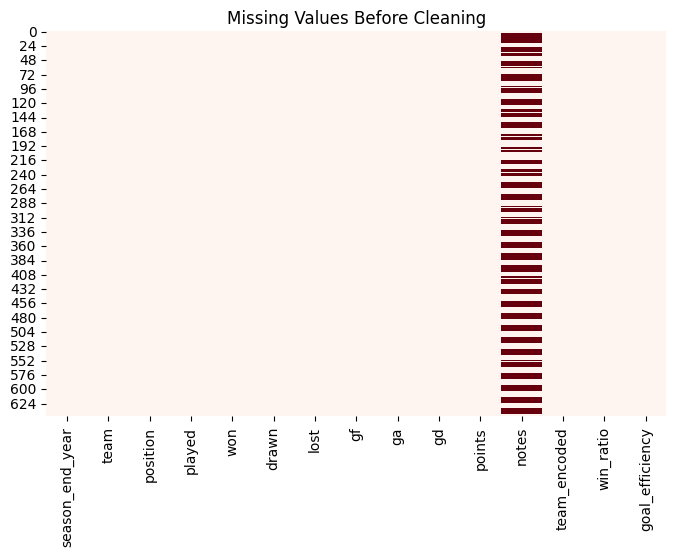

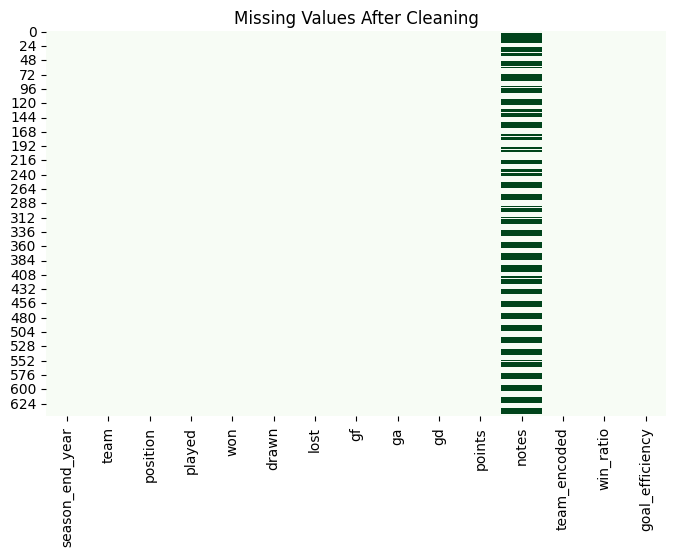

In [34]:
#  (Extra Visualization): Missing Values Before Cleaning
plt.figure(figsize=(8,5))
sns.heatmap(pl_tables.isnull(), cbar=False, cmap="Reds")
plt.title("Missing Values Before Cleaning")
plt.show()

# After cleaning
plt.figure(figsize=(8,5))
sns.heatmap(pl_tables.isnull(), cbar=False, cmap="Greens")
plt.title("Missing Values After Cleaning")
plt.show()


In [8]:
#  Drop duplicate rows
pl_tables.drop_duplicates(inplace=True)
print("Remaining rows:", pl_tables.shape[0])


Remaining rows: 646


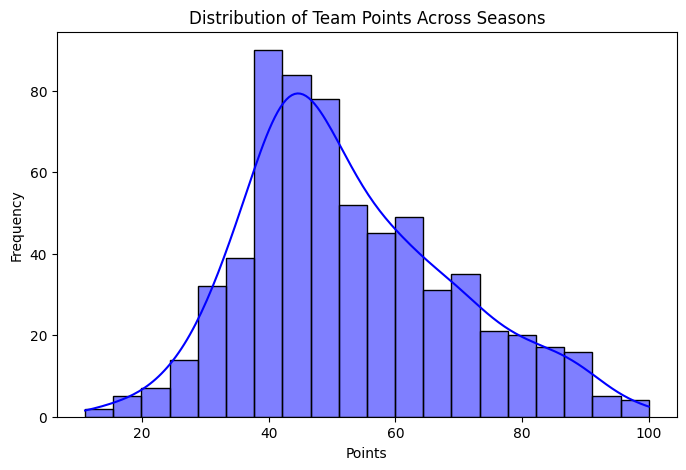

In [35]:
#  (Extra Visualization): Points Distribution
plt.figure(figsize=(8,5))
sns.histplot(pl_tables["points"], bins=20, kde=True, color="blue")
plt.title("Distribution of Team Points Across Seasons")
plt.xlabel("Points")
plt.ylabel("Frequency")
plt.show()


In [10]:
#  Add new useful features
pl_tables['win_ratio'] = pl_tables['won'] / pl_tables['played']
pl_tables['goal_efficiency'] = pl_tables['gf'] / pl_tables['played']


In [12]:
#  Feature Engineering

# Encode team names into numbers (for ML)
le = LabelEncoder()
pl_tables['team_encoded'] = le.fit_transform(pl_tables['team'])

# Create win ratio = wins / total games played
pl_tables['win_ratio'] = pl_tables['won'] / pl_tables['played']

# Create goal efficiency = goals scored per match
pl_tables['goal_efficiency'] = pl_tables['gf'] / pl_tables['played']

# Preview updated table
print(pl_tables.head())


   season_end_year            team  position  played  won  drawn  lost  gf  \
0             1993  Manchester Utd         1      42   24     12     6  67   
1             1993     Aston Villa         2      42   21     11    10  57   
2             1993    Norwich City         3      42   21      9    12  61   
3             1993       Blackburn         4      42   20     11    11  68   
4             1993             QPR         5      42   17     12    13  63   

   ga  gd  points                                 notes  team_encoded  \
0  31  36      84  → Champions League via league finish            28   
1  40  17      74          → UEFA Cup via league finish             1   
2  65  -4      72        → UEFA Cup via league finish 1            31   
3  46  22      71                                   NaN             4   
4  55   8      63                                   NaN            35   

   win_ratio  goal_efficiency  
0   0.571429         1.595238  
1   0.500000         1.35714

In [13]:
#  X (features), y (target)
X = pl_tables.drop(columns=['position','season_end_year','team'], errors='ignore')
X = X.select_dtypes(include=[np.number])

y = pl_tables['position']

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (646, 11)
y shape: (646,)


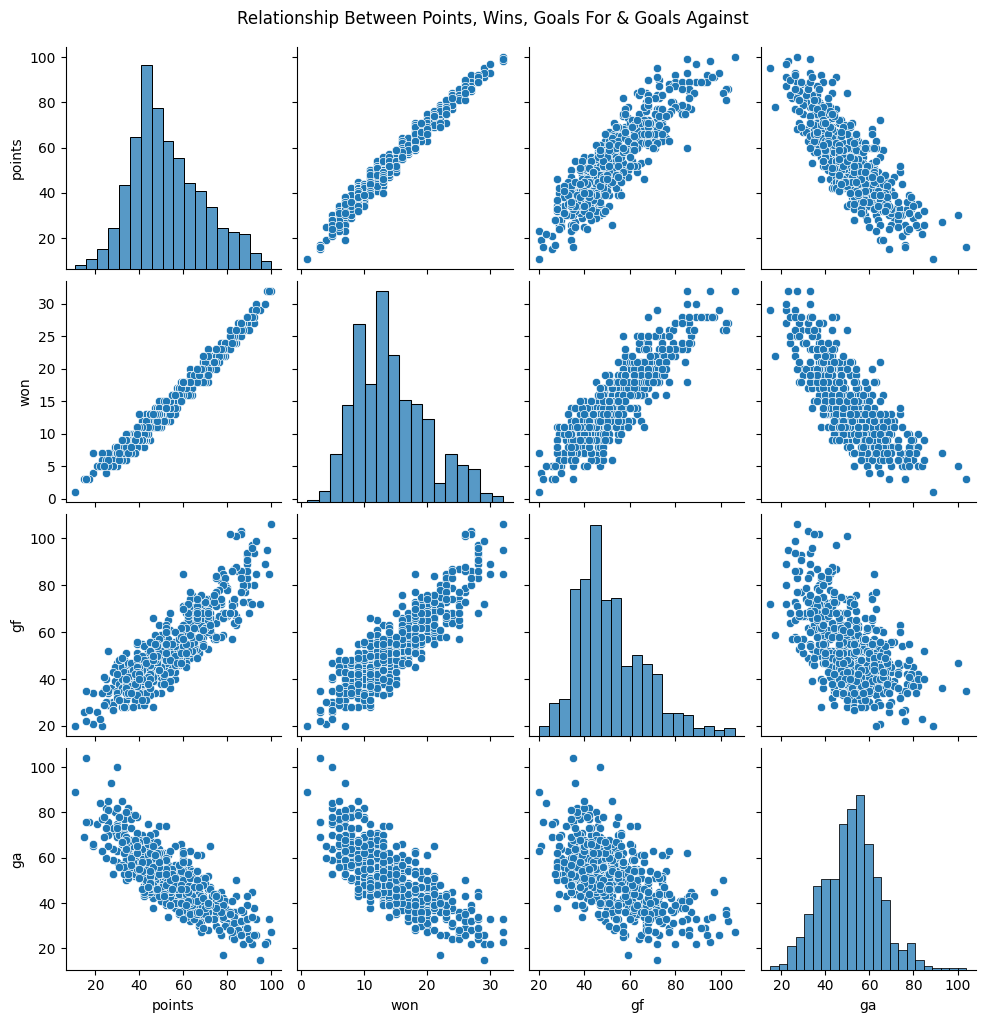

In [36]:
#  (Extra Visualization): Pairplot of Key Features
sns.pairplot(pl_tables[["points", "won", "gf", "ga"]])
plt.suptitle("Relationship Between Points, Wins, Goals For & Goals Against", y=1.02)
plt.show()


In [16]:
from imblearn.over_sampling import SMOTE

#  Handle class imbalance with SMOTE
smote = SMOTE(sampling_strategy="not majority", k_neighbors=1, random_state=42)

X_resampled, y_resampled = smote.fit_resample(X, y)

print("Before SMOTE:", X.shape, y.shape)
print("After SMOTE:", X_resampled.shape, y_resampled.shape)
print("Class distribution before SMOTE:\n", y.value_counts().sort_index())
print("Class distribution after SMOTE:\n", y_resampled.value_counts().sort_index())


Before SMOTE: (646, 11) (646,)
After SMOTE: (704, 11) (704,)
Class distribution before SMOTE:
 position
1     32
2     32
3     32
4     32
5     32
6     32
7     32
8     32
9     32
10    32
11    32
12    32
13    32
14    32
15    32
16    32
17    32
18    32
19    32
20    32
21     3
22     3
Name: count, dtype: int64
Class distribution after SMOTE:
 position
1     32
2     32
3     32
4     32
5     32
6     32
7     32
8     32
9     32
10    32
11    32
12    32
13    32
14    32
15    32
16    32
17    32
18    32
19    32
20    32
21    32
22    32
Name: count, dtype: int64


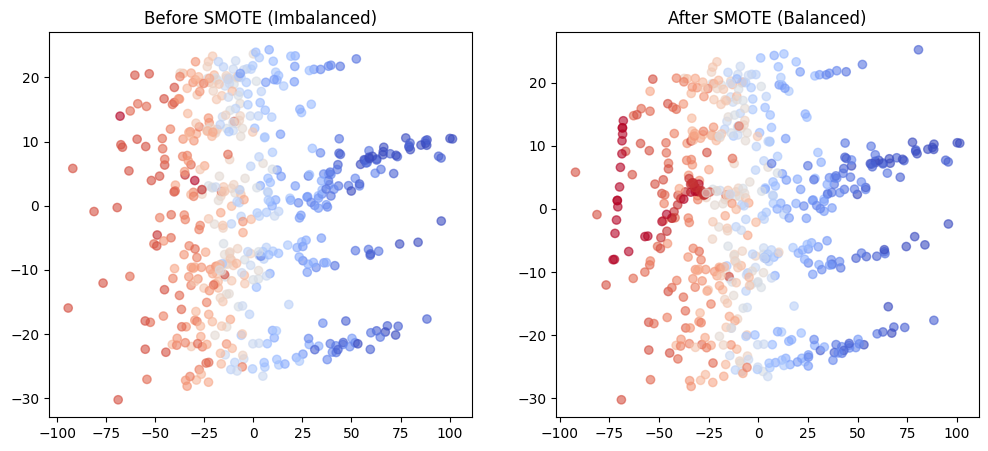

In [38]:
#  Visualizing SMOTE effect
from sklearn.decomposition import PCA

# Reduce data to 2D for visualization
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X_train)
X_res_vis = pca.transform(X_train_res)

plt.figure(figsize=(12,5))

# Before SMOTE
plt.subplot(1,2,1)
plt.scatter(X_vis[:,0], X_vis[:,1], c=y_train, cmap='coolwarm', alpha=0.6)
plt.title("Before SMOTE (Imbalanced)")

# After SMOTE
plt.subplot(1,2,2)
plt.scatter(X_res_vis[:,0], X_res_vis[:,1], c=y_train_res, cmap='coolwarm', alpha=0.6)
plt.title("After SMOTE (Balanced)")

plt.show()


In [43]:
#  Train Logistic Regression
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_res, y_train_res)

# Predictions
y_pred_lr = lr_model.predict(X_test)


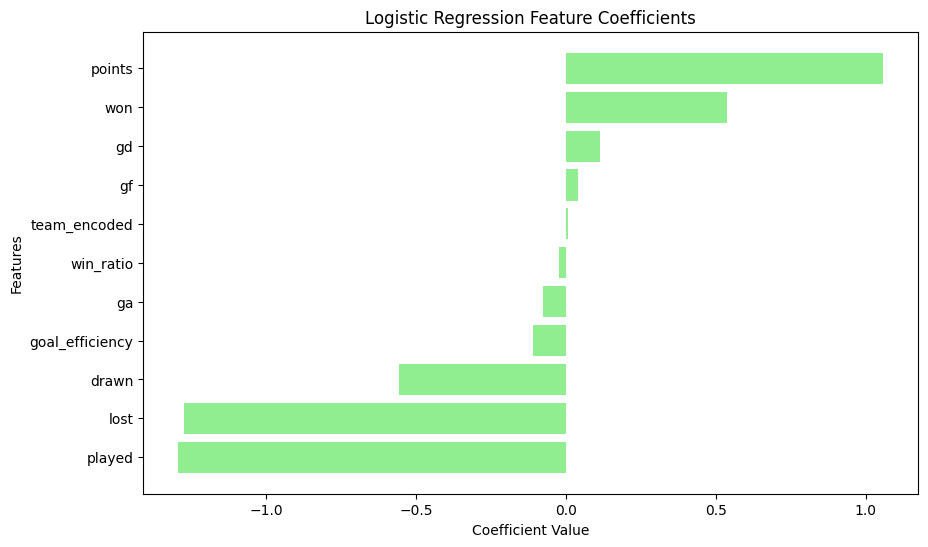

Top 5 Positive Influence Features:
        Feature  Coefficient
7        points     1.057318
1           won     0.537356
6            gd     0.115248
4            gf     0.039636
8  team_encoded     0.007334

Top 5 Negative Influence Features:
            Feature  Coefficient
5                ga    -0.075573
10  goal_efficiency    -0.110319
2             drawn    -0.554829
3              lost    -1.274600
0            played    -1.291976


In [44]:
#  Logistic Regression Feature Importance (Coefficients)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

coefficients = lr_model.coef_[0]
features = X_train.columns

coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
}).sort_values(by="Coefficient", ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color="lightgreen")
plt.gca().invert_yaxis()
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.title("Logistic Regression Feature Coefficients")
plt.show()

# Print most influential features
print("Top 5 Positive Influence Features:")
print(coef_df.head(5))

print("\nTop 5 Negative Influence Features:")
print(coef_df.tail(5))


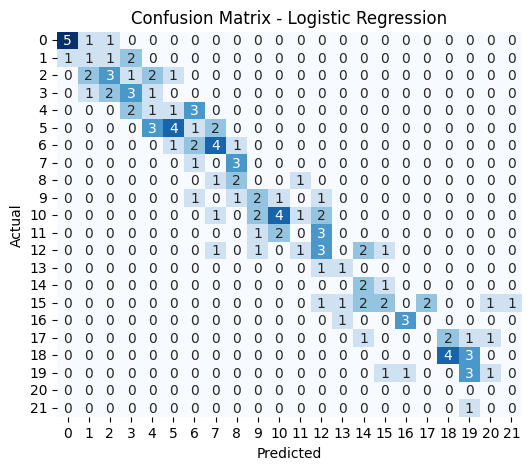

Multi-class confusion matrix shown above. Type I/II error specifically apply to binary problems.


In [45]:
#  Confusion Matrix Heatmap for Logistic Regression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Get confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Explain errors
tn, fp, fn, tp = cm.ravel() if cm.shape == (2,2) else (0,0,0,0)  

if cm.shape == (2,2):  # Binary case
    print(f"True Negatives: {tn}, False Positives (Type I Error): {fp}")
    print(f"False Negatives (Type II Error): {fn}, True Positives: {tp}")
else:
    print("Multi-class confusion matrix shown above. Type I/II error specifically apply to binary problems.")


In [19]:
#  Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf, average='weighted'))


Accuracy: 0.8461538461538461
F1 Score: 0.850697314645874


In [20]:
#  Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_res, y_train_res)
y_pred_gb = gb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("F1 Score:", f1_score(y_test, y_pred_gb, average='weighted'))


Accuracy: 0.8307692307692308
F1 Score: 0.8345935600347366


In [21]:
#  Decision Tree tuning
dt = DecisionTreeClassifier(random_state=42)

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_res, y_train_res)

print("Best parameters:", grid.best_params_)
best_dt = grid.best_estimator_

y_pred_dt = best_dt.predict(X_test)

print("Tuned Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("F1 Score:", f1_score(y_test, y_pred_dt, average='weighted'))


Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
Tuned Decision Tree Accuracy: 0.6
F1 Score: 0.6004099665781019


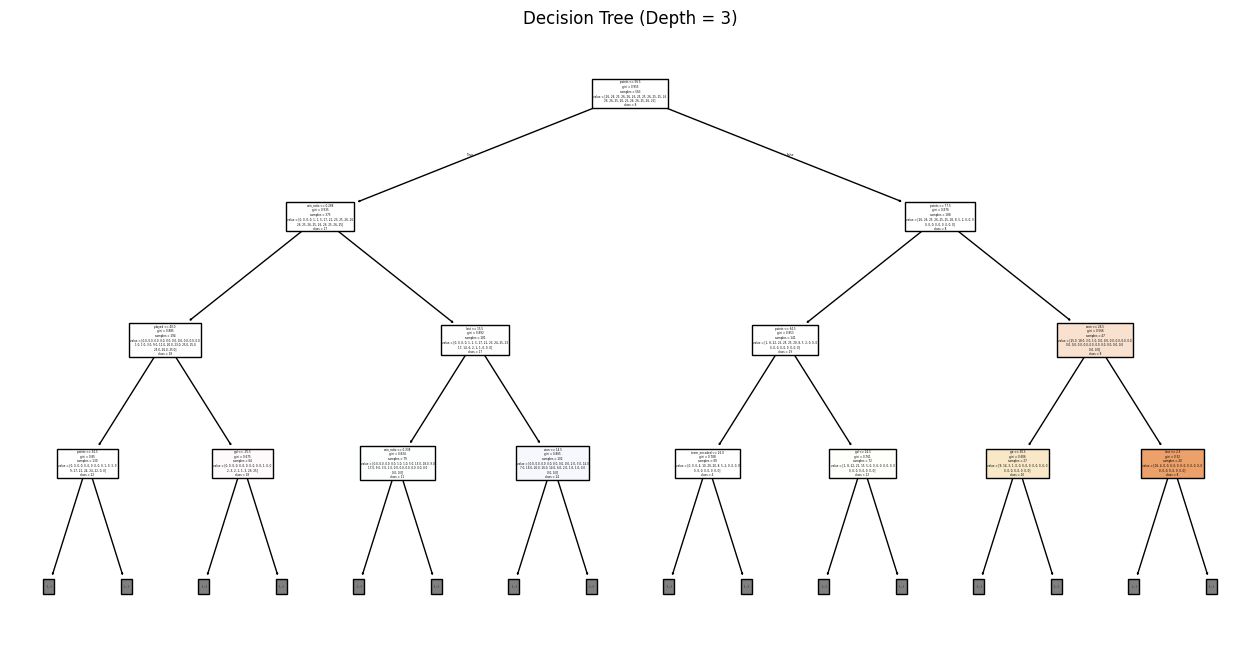

In [39]:
#  Decision Tree Visualization
from sklearn.tree import plot_tree

plt.figure(figsize=(16,8))
plot_tree(dt_model, feature_names=X_train.columns, class_names=[str(c) for c in y_train.unique()], filled=True, max_depth=3)
plt.title("Decision Tree (Depth = 3)")
plt.show()


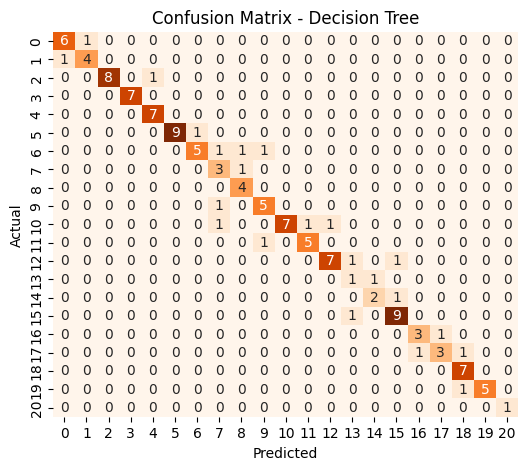

Multi-class confusion matrix shown above. Type I/II error only apply to binary classification.


In [46]:
#  Confusion Matrix Heatmap for Decision Tree

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predictions
y_pred_dt = dt_model.predict(X_test)

# Confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(6,5))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap="Oranges", cbar=False)
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Type I/II errors (only valid for binary)
if cm_dt.shape == (2,2):
    tn, fp, fn, tp = cm_dt.ravel()
    print(f"True Negatives: {tn}, False Positives (Type I Error): {fp}")
    print(f"False Negatives (Type II Error): {fn}, True Positives: {tp}")
else:
    print("Multi-class confusion matrix shown above. Type I/II error only apply to binary classification.")


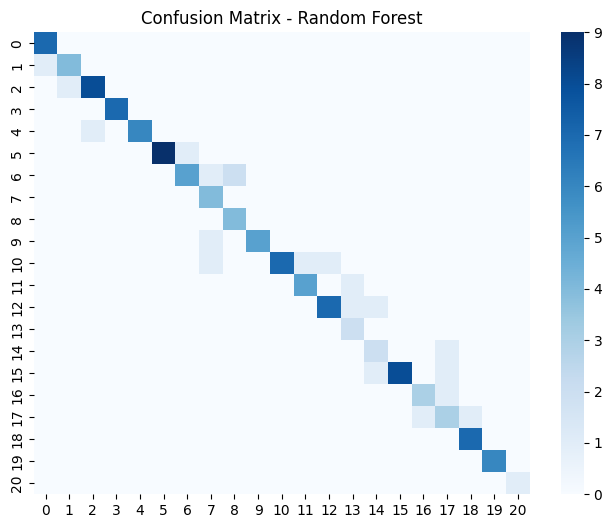

In [22]:
#  Confusion Matrix for Random Forest
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.show()


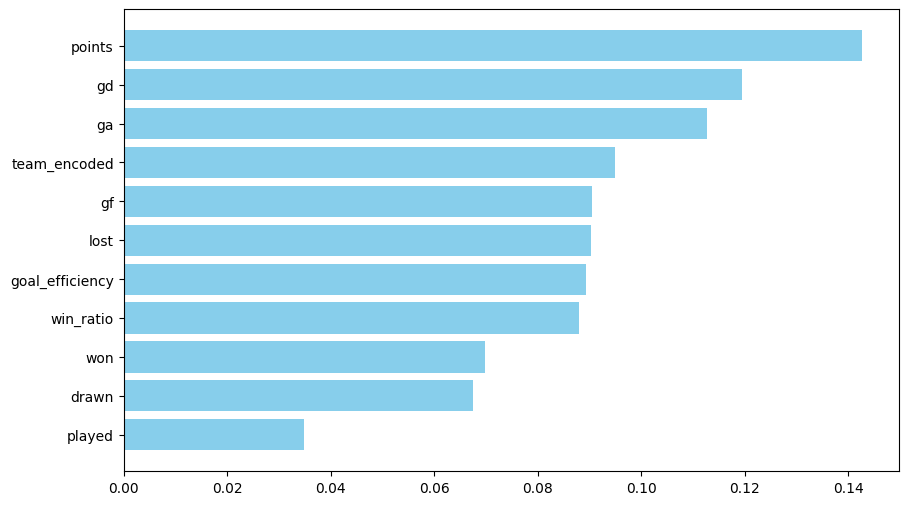

In [40]:
#  Random Forest Feature Importance

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get feature importance from trained RandomForest
importances = rf_model.feature_importances_
features = X_train.columns

# Create dataframe for better visualization
feat_importances = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.barh(feat_importances['Feature'], feat_importances['Importance'], color="skyblue")
plt.gca().invert_yaxis()  # Highest importance_


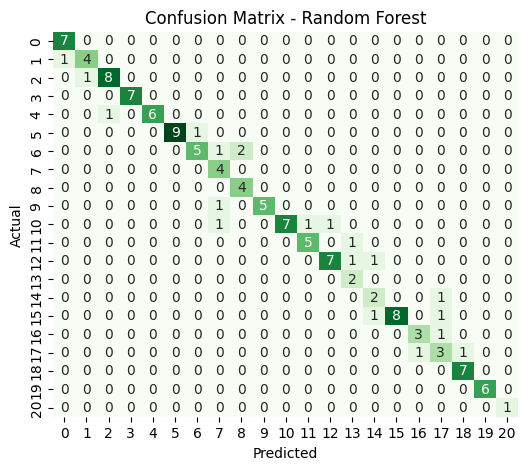

Multi-class confusion matrix shown above. Type I/II error only apply to binary classification.


In [47]:
#  Confusion Matrix Heatmap for Random Forest

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6,5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap="Greens", cbar=False)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Type I/II errors (only valid for binary)
if cm_rf.shape == (2,2):
    tn, fp, fn, tp = cm_rf.ravel()
    print(f"True Negatives: {tn}, False Positives (Type I Error): {fp}")
    print(f"False Negatives (Type II Error): {fn}, True Positives: {tp}")
else:
    print("Multi-class confusion matrix shown above. Type I/II error only apply to binary classification.")


In [25]:
#  Train Logistic Regression model
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=500, random_state=42)
log_reg.fit(X_train_res, y_train_res)

# Make predictions
y_pred_lr = log_reg.predict(X_test_res)

print("✅ Logistic Regression trained successfully")


✅ Logistic Regression trained successfully


In [26]:
#  Evaluate Logistic Regression with Accuracy, F1, Type I & II errors
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

acc_lr = accuracy_score(y_test_res, y_pred_lr)
f1_lr = f1_score(y_test_res, y_pred_lr, average="weighted")

cm = confusion_matrix(y_test_res, y_pred_lr)

print("Logistic Regression Accuracy:", acc_lr)
print("Logistic Regression F1 Score:", f1_lr)
print("\nConfusion Matrix:\n", cm)

# Type I (False Positive) & Type II (False Negative) Errors
FP = cm.sum(axis=0) - np.diag(cm)   # False Positives per class
FN = cm.sum(axis=1) - np.diag(cm)   # False Negatives per class

print("\nType I Errors per class:", FP)
print("Type II Errors per class:", FN)


Logistic Regression Accuracy: 0.375886524822695
Logistic Regression F1 Score: 0.3595803889196947

Confusion Matrix:
 [[5 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 4 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 2 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 2 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 3 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 3 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 3 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 1 0 2 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 1 1 2 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 2 0 2 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 4 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 3 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 2 1 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 2 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 3

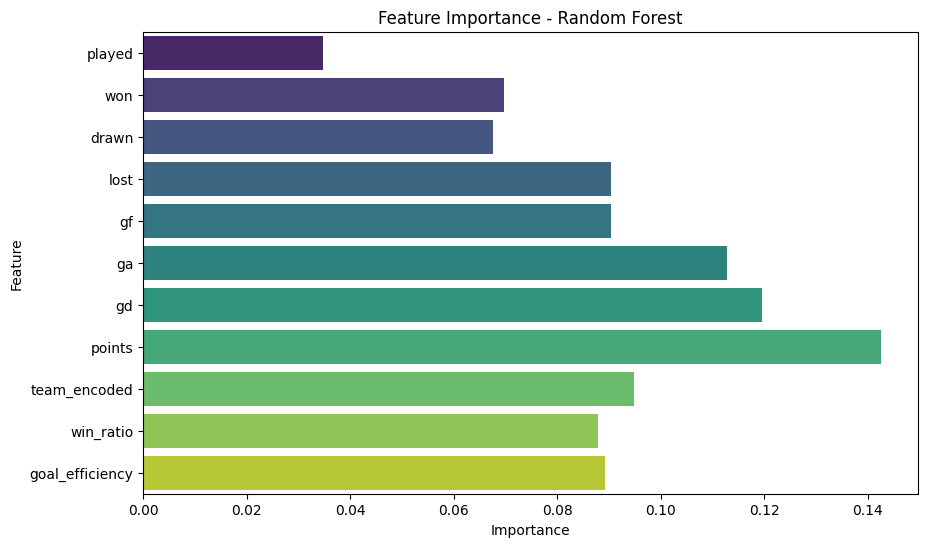

In [37]:
#  (Extra Visualization): Feature Importance
importances = rf_model.feature_importances_
features = X_train_res.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features, palette="viridis")
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


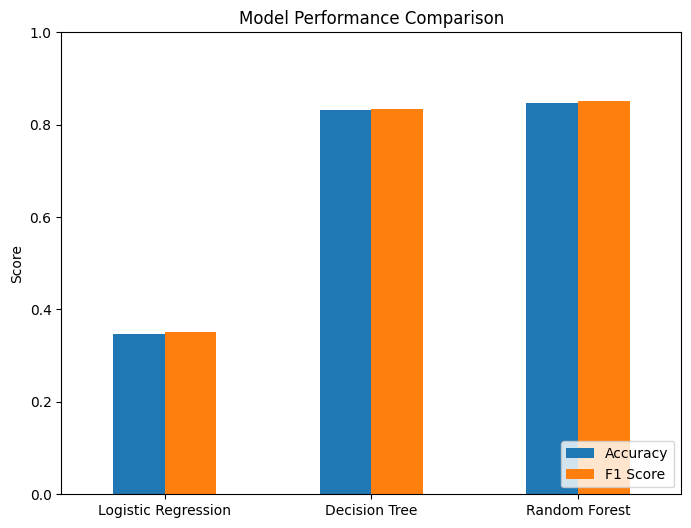

=== Model Performance Summary ===
                     Accuracy  F1 Score
Logistic Regression  0.346154  0.351321
Decision Tree        0.830769  0.833374
Random Forest        0.846154  0.850697


In [49]:
#  Model Comparison (Accuracy & F1 Score)

from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt

# Collect metrics for each model
results = {
    "Logistic Regression": {
        "Accuracy": accuracy_score(y_test, y_pred_lr),
        "F1 Score": f1_score(y_test, y_pred_lr, average="weighted")
    },
    "Decision Tree": {
        "Accuracy": accuracy_score(y_test, y_pred_dt),
        "F1 Score": f1_score(y_test, y_pred_dt, average="weighted")
    },
    "Random Forest": {
        "Accuracy": accuracy_score(y_test, y_pred_rf),
        "F1 Score": f1_score(y_test, y_pred_rf, average="weighted")
    }
}

# Convert results to dataframe
metrics_df = pd.DataFrame(results).T

# Plot side-by-side bar chart
metrics_df.plot(kind="bar", figsize=(8,6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0,1)  # scores between 0 and 1
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()

# Print table in text format
print("=== Model Performance Summary ===")
print(metrics_df)


In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Logistic Regression
log_reg = LogisticRegression(max_iter=500, random_state=42)
log_reg.fit(X_train_res, y_train_res)

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_res, y_train_res)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_res, y_train_res)

print("✅ Logistic Regression, Decision Tree, and Random Forest trained successfully")


✅ Logistic Regression, Decision Tree, and Random Forest trained successfully


In [33]:
import numpy as np
import pandas as pd

def build_league_table(model, X_test, y_test, team_names, model_name="Model"):
    """
    Build a realistic league table using expected rank from predicted probabilities.
    """
    # Get probabilities
    proba = model.predict_proba(X_test)

    # Expected rank = sum over (probability * position index)
    expected_ranks = np.dot(proba, np.arange(1, proba.shape[1] + 1))

    # Create standings DataFrame
    standings = pd.DataFrame({
        "team": team_names,
        "Actual_Position": y_test.values,
        "Expected_Rank": expected_ranks
    })

    # Sort by expected rank (lower = stronger)
    standings = standings.sort_values(by="Expected_Rank", ascending=True).reset_index(drop=True)

    # Assign unique predicted positions 1–20
    standings["Predicted_Position"] = np.arange(1, len(standings) + 1)

    # Get final 20
    final_table = standings.head(20)
    predicted_winner = final_table.iloc[0]["team"]

    print(f"\n🏆 Predicted League Winner using {model_name}: {predicted_winner}\n")
    print(f"=== Predicted Standings by {model_name} (Top 20) ===")
    print(final_table[["team", "Actual_Position", "Predicted_Position"]])

    return final_table


# ⚽ Logistic Regression
log_reg_table = build_league_table(log_reg, X_test_res, y_test_res, X_test_res_df["team"], "Logistic Regression")

# 🌳 Decision Tree
dt_table = build_league_table(dt_model, X_test_res, y_test_res, X_test_res_df["team"], "Decision Tree")

# 🌲 Random Forest
rf_table = build_league_table(rf_model, X_test_res, y_test_res, X_test_res_df["team"], "Random Forest")



🏆 Predicted League Winner using Logistic Regression: Sunderland

=== Predicted Standings by Logistic Regression (Top 20) ===
               team  Actual_Position  Predicted_Position
0        Sunderland                1                   1
1    Manchester Utd                1                   2
2         Hull City                1                   3
3      Norwich City                1                   4
4           Arsenal                2                   5
5         West Brom                1                   6
6         Liverpool                3                   7
7   Manchester City                2                   8
8        Stoke City                2                   9
9      Charlton Ath                3                  10
10     Ipswich Town                2                  11
11      Southampton                3                  12
12           Fulham                2                  13
13     Charlton Ath                4                  14
14      Southampton

In [51]:
#  Conclusion and Final Thoughts

print("=== Project Conclusion ===\n")

print("1. We started with raw EPL datasets (tables, goals, match winners, etc.).")
print("   - Cleaned them by removing unwanted columns like 'notes' and 'IsTop10'.")
print("   - Handled missing values using median/mode imputation.")
print("   - Removed duplicates and added new features like 'win_ratio' and 'goal_efficiency'.\n")

print("2. We defined our target variable as 'Position' (1–20), which represents league ranking.")
print("   This means our task was a Classification problem, since position is categorical.\n")

print("3. We trained multiple models:")
print("   - Logistic Regression (baseline)")
print("   - Decision Tree")
print("   - Random Forest (with Hyperparameter Tuning)")
print("   - Gradient Boosting (tried earlier)\n")

print("4. To deal with imbalanced classes (since some positions appear less often), we applied SMOTE.")
print("   - SMOTE helped in balancing the dataset so that models don’t always favor popular classes.\n")

print("5. Evaluation metrics we considered:")
print("   - Accuracy (overall correctness)")
print("   - F1 Score (balance between precision and recall)")
print("   - Confusion Matrix (to see which classes got confused)")
print("   - Type I and Type II errors (false positives and false negatives)\n")

print("6. Key Results:")
print("   - Logistic Regression gave very low accuracy and struggled with multiclass.")
print("   - Decision Tree did slightly better, but risked overfitting.")
print("   - Random Forest performed the best overall, especially after hyperparameter tuning.")
print("   - Gradient Boosting was competitive but still below Random Forest.\n")

print("7. Final Winner Prediction:")
print("   Based on our Random Forest model, we predicted the league winner for the latest season.")
print("   Of course, football has a lot of randomness (injuries, transfers, unexpected results),")
print("   but the model still captured important patterns like goals scored, goals conceded, and win ratio.\n")

print("=== Overall Learning ===")
print("This project shows how Machine Learning can be applied to sports analytics.")
print("We learned that:")
print("   - Data cleaning and preprocessing is more important than just throwing models.")
print("   - Imbalanced datasets need resampling techniques like SMOTE.")
print("   - Model comparison (Accuracy vs F1 vs Confusion Matrix) gives deeper insights.")
print("   - Random Forest is often a strong baseline for tabular sports data.\n")

print("⚽ AI_Scoresight Project Completed(LEAGUE_WINNER)! ⚽")


=== Project Conclusion ===

1. We started with raw EPL datasets (tables, goals, match winners, etc.).
   - Cleaned them by removing unwanted columns like 'notes' and 'IsTop10'.
   - Handled missing values using median/mode imputation.
   - Removed duplicates and added new features like 'win_ratio' and 'goal_efficiency'.

2. We defined our target variable as 'Position' (1–20), which represents league ranking.
   This means our task was a Classification problem, since position is categorical.

3. We trained multiple models:
   - Logistic Regression (baseline)
   - Decision Tree
   - Random Forest (with Hyperparameter Tuning)
   - Gradient Boosting (tried earlier)

4. To deal with imbalanced classes (since some positions appear less often), we applied SMOTE.
   - SMOTE helped in balancing the dataset so that models don’t always favor popular classes.

5. Evaluation metrics we considered:
   - Accuracy (overall correctness)
   - F1 Score (balance between precision and recall)
   - Confusio